In [1]:
#%matplotlib notebook
import math
import numpy as np
from astropy import constants as co

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import copy

from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import griddata

In [2]:
#--- We use cgs units -----
Msun=co.M_sun.cgs.value
c=co.c.cgs.value
G=co.G.cgs.value
pc=co.pc.cgs.value
tenkpc=1e4*pc

## Long-bar technical report paper (Ott et al 2010)
https://dcc.ligo.org/LIGO-T1000553/public

In [3]:
# Moments of inertia os a cylinder (symmetry axis = y)
def Calculate_Iij_bar (M,R,LoR):
    Ixx = 1./12. * M*R**2 *(3.+(LoR)**2)
    Iyy = 0.5 * M * R**2
    Izz = Ixx
    return Ixx, Iyy, Izz
# Compute ellipticity from moments of inertia (rotation axis - z)
def Calculate_eps (Ixx,Iyy,Izz):
    return (Ixx-Iyy)/Izz

In [4]:
# Maximum possible values for Ott et al 2010 technical report
M=1.5*Msun  # in Ott et al 2010 ranges between 0.15 and 1.5 Msun
R=20e5      #[cm] in Ott et al 2010 ranges between 5 and 20 km
LoR=6.      # in Ott et al 2010 L/R ranges from 1 to 6
Ixx, Iyy, Izz=Calculate_Iij_bar(M,R,LoR)
eps = Calculate_eps (Ixx, Iyy, Izz)
print ("----- Maximum value -------")
print ("ellipticity = ",eps)
print ("Ixx         = ",Ixx/1e45," x 10^45 g cm^2")
print ("Iyy         = ",Iyy/1e45," x 10^45 g cm^2")
print ("Izz         = ",Izz/1e45," x 10^45 g cm^2")
print ("Note that this numbers are much larger than the canonical NS value of 10^45 g cm^2.")
# Minimum values
M=0.15*Msun  # in Ott et al 2010 ranges between 0.15 and 1.5 Msun
R=5e5      #[cm] in Ott et al 2010 ranges between 5 and 20 km
LoR=1.      # in Ott et al 2010 L/R ranges from 1 to 6
Ixx, Iyy, Izz=Calculate_Iij_bar(M,R,LoR)
eps = Calculate_eps (Ixx, Iyy, Izz)
print ("----- Minimum value -------")
print ("ellipticity = ",eps)
print ("Ixx         = ",Ixx/1e45," x 10^45 g cm^2")
print ("Iyy         = ",Iyy/1e45," x 10^45 g cm^2")
print ("Izz         = ",Izz/1e45," x 10^45 g cm^2")

----- Maximum value -------
ellipticity =  0.8461538461538461
Ixx         =  38.773992478611994  x 10^45 g cm^2
Iyy         =  5.965229612094154  x 10^45 g cm^2
Izz         =  38.773992478611994  x 10^45 g cm^2
Note that this numbers are much larger than the canonical NS value of 10^45 g cm^2.
----- Minimum value -------
ellipticity =  -0.5
Ixx         =  0.024855123383725638  x 10^45 g cm^2
Iyy         =  0.037282685075588455  x 10^45 g cm^2
Izz         =  0.024855123383725638  x 10^45 g cm^2


## Data from the O1+O2 targeted search for CCSNe
https://journals.aps.org/prd/abstract/10.1103/PhysRevD.101.084002

In [5]:
###### Class definitions ######
# Parameters of the sine-Gaussian model
class SGmodel:
    name="" # name of the model
    f=0. # frequency of the signal (Hz)
    tau=0. # tau (s)
    hten=0. # hrss value at 10kpc for the base signal
    M=0.
    R=0.
    LoR=0.
# Data from the EM SN observation
class SNobs:
    name=""
    D=0. #distance in cm
# Limits set by GW detector data
class GWobs:
    hrss=0. # Upper limit on hrss at the detector
    hten=0. # Upper limit on hrss at 10 kpc
    h0=0. # Upper limit on the amplitude of the sine-Gaussian
    Izzeps=0. # Upper limit on the combination Izz * ellipticity 
    EGW=0. # Upper limit on the GW emergy emmitted

In [6]:
SGs={}
#---------------------------------------------------------------------
#---- Parameters used for the extreme emision models -----------------
#---------------------------------------------------------------------

#---- Data for the long-bar models (table IV and text in IV.C.2) -----
# Note the typo in table IV: 1e-22 -> 1e-20
# According to Gossan et al 2016 (arxiv:1511.02836) tau is 1/4 of the 
# duration, however it seems that in the collaboration papers tau = duration 

SGkey="lb1"
SGs[SGkey]=SGmodel()
SGs[SGkey].name="lb1"
SGs[SGkey].f=800. 
SGs[SGkey].tau=0.1
SGs[SGkey].hten=1.48e-20
SGs[SGkey].M=0.2*Msun
SGs[SGkey].R=10e5
SGs[SGkey].LoR=6.

SGkey="lb2"
SGs[SGkey]=SGmodel()
SGs[SGkey].name="lb2"
SGs[SGkey].f=800.
SGs[SGkey].tau=1
SGs[SGkey].hten=4.682e-20
SGs[SGkey].M=0.2*Msun
SGs[SGkey].R=10e5
SGs[SGkey].LoR=6.

SGkey="lb3"
SGs[SGkey]=SGmodel()
SGs[SGkey].name="lb3"
SGs[SGkey].f=1600.
SGs[SGkey].tau=0.1
SGs[SGkey].hten=5.92e-20
SGs[SGkey].M=0.2*Msun
SGs[SGkey].R=10e5
SGs[SGkey].LoR=6.

SGkey="lb4"
SGs[SGkey]=SGmodel()
SGs[SGkey].name="lb4"
SGs[SGkey].f=800.
SGs[SGkey].tau=0.1
SGs[SGkey].hten=7.398e-20
SGs[SGkey].M=1.0*Msun
SGs[SGkey].R=10e5
SGs[SGkey].LoR=6.

SGkey="lb5"
SGs[SGkey]=SGmodel()
SGs[SGkey].name="lb5"
SGs[SGkey].f=800.
SGs[SGkey].tau=1.
SGs[SGkey].hten=23.411e-20
SGs[SGkey].M=1.0*Msun
SGs[SGkey].R=10e5
SGs[SGkey].LoR=6.

SGkey="lb6"
SGs[SGkey]=SGmodel()
SGs[SGkey].name="lb6"
SGs[SGkey].f=1601.
SGs[SGkey].tau=25e-3
SGs[SGkey].hten=14.777e-20
SGs[SGkey].M=1.0*Msun
SGs[SGkey].R=10e5
SGs[SGkey].LoR=6.

#------ Data for the sine-Gaussian (ad-hoc) models (table IV and text in IV.C.3) -----
# tau = Q / (sqrt(2 * pi) * f0), being Q=8.9 : Note that in Abbott et al 2016, 2020 pi
# is outside the sqrt. It should be inside as described in Gossan et al 2016.

SGkey="sg1"
SGs[SGkey]=SGmodel()
SGs[SGkey].name="sg1"
SGs[SGkey].f=235.
SGs[SGkey].tau=8.9/np.sqrt(2.*math.pi)/SGs[SGkey].f

SGkey="sg2"
SGs[SGkey]=SGmodel()
SGs[SGkey].name="sg2"
SGs[SGkey].f=1304.
SGs[SGkey].tau=8.9/np.sqrt(2.*math.pi)/SGs[SGkey].f

SGkey="sg3"
SGs[SGkey]=SGmodel()
SGs[SGkey].name="sg3"
SGs[SGkey].f=235.
SGs[SGkey].tau=8.9/np.sqrt(2.*math.pi)/SGs[SGkey].f

SGkey="sg4"
SGs[SGkey]=SGmodel()
SGs[SGkey].name="sg4"
SGs[SGkey].f=1304.
SGs[SGkey].tau=8.9/np.sqrt(2.*math.pi)/SGs[SGkey].f

# Summary table
for SGkey in SGs.keys():
    print (SGkey, ", tau = ", '{:7.2f}'.format(SGs[SGkey].tau*1000), "ms", 
           ", f = ",'{:7.1f}'.format(SGs[SGkey].f)," Hz")

lb1 , tau =   100.00 ms , f =    800.0  Hz
lb2 , tau =  1000.00 ms , f =    800.0  Hz
lb3 , tau =   100.00 ms , f =   1600.0  Hz
lb4 , tau =   100.00 ms , f =    800.0  Hz
lb5 , tau =  1000.00 ms , f =    800.0  Hz
lb6 , tau =    25.00 ms , f =   1601.0  Hz
sg1 , tau =    15.11 ms , f =    235.0  Hz
sg2 , tau =     2.72 ms , f =   1304.0  Hz
sg3 , tau =    15.11 ms , f =    235.0  Hz
sg4 , tau =     2.72 ms , f =   1304.0  Hz


In [7]:
#---------------------------------------------------------------------
#----------    Distance to different SNe -----------------------------
#---------------------------------------------------------------------

#------ Data from table I ------------------------
SNs={}

SNkey="SN2015as"
SNs[SNkey]=SNobs()
SNs[SNkey].name="SN 2015as"
SNs[SNkey].D=19.2e6*pc

SNkey="SN2016B"
SNs[SNkey]=SNobs()
SNs[SNkey].name="SN 2016B"
SNs[SNkey].D=19.1e6*pc

SNkey="SN2016X"
SNs[SNkey]=SNobs()
SNs[SNkey].name="SN 2016X"
SNs[SNkey].D=15.2e6*pc

SNkey="SN2017eaw"
SNs[SNkey]=SNobs()
SNs[SNkey].name="SN 2017eaw"
SNs[SNkey].D=6.72e6*pc

SNkey="SN2017gax"
SNs[SNkey]=SNobs()
SNs[SNkey].name="SN 2017gax"
SNs[SNkey].D=19.7e6*pc

# Summary table
for SNkey in SNs.keys():
    print('{:<10}'.format(SNkey), ", D = ",'{:5g}'.format(SNs[SNkey].D/1e6/pc)," Mpc")

SN2015as   , D =   19.2  Mpc
SN2016B    , D =   19.1  Mpc
SN2016X    , D =   15.2  Mpc
SN2017eaw  , D =   6.72  Mpc
SN2017gax  , D =   19.7  Mpc


In [8]:
#---------------------------------------------------------------------
#----------- Constraints set from the non-observation ----------------
#-----------   of associated GWs during O1 and O2     ----------------
#---------------------------------------------------------------------
GWs={}


for SNkey in SNs.keys(): 
    for SGkey in SGs.keys():
        key =(SNkey,SGkey)
        GWs[key]=GWobs()
# Rescale hrss values @ 10 kpc to the real distance
#for SNkey in SNs.keys(): #("SN2017eaw", "SN2017gax"):
#    for SGkey in ("lb1","lb2","lb3","lb4","lb5","lb6"):
#        key =(SNkey,SGkey)
#        GWs[key]=GWobs()
#        GWs[key].hrss=SGs[SGkey].hten*tenkpc/SNs[SNkey].D

# 

#---- Limits on the long-bar modes (table VII) ----------
# Table VII in the paper gives the distance (D_det) with a 50% detection efficiency
# at which this signal could be observed if it were located in ths same
# sky location as the corresponding supernova (but at a different distance, which is D_SN).
# If we put the source at D_det, the hrss will be hten*10kpc/D_det.
SNkey ="SN2015as"

SGkey="lb1"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(0.93e6*pc) # hrss = hten * 10kpc / D_det
SGkey="lb2"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(2.93e6*pc)
SGkey="lb3"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(1.92e6*pc)
SGkey="lb4"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(4.59e6*pc)
SGkey="lb5"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(15.24e6*pc)
SGkey="lb6"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(4.86e6*pc)


SNkey ="SN2016B"

SGkey="lb1"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(0.8e6*pc)
SGkey="lb2"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(2.64e6*pc)
SGkey="lb3"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(1.8e6*pc)
SGkey="lb4"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(4.24e6*pc)
SGkey="lb5"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(13.69e6*pc)
SGkey="lb6"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(4.5e6*pc)
        
SNkey ="SN2016X"

SGkey="lb1"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(0.73e6*pc)
SGkey="lb2"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(2.36e6*pc)
SGkey="lb3"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(1.46e6*pc)
SGkey="lb4"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(3.83e6*pc)
SGkey="lb5"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(12.16e6*pc)
SGkey="lb6"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(3.73e6*pc)

SNkey ="SN2017eaw"

SGkey="lb1"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(0.76e6*pc)
SGkey="lb2"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(2.58e6*pc)
SGkey="lb3"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(1.76e6*pc)
SGkey="lb4"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(4.36e6*pc)
SGkey="lb5"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(12.37e6*pc)
SGkey="lb6"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(4.15e6*pc)


SNkey ="SN2017gax"

SGkey="lb1"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(1.23e6*pc)
SGkey="lb2"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(3.55e6*pc)
SGkey="lb3"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(2.63e6*pc)
SGkey="lb4"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(6.16e6*pc)
SGkey="lb5"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(19.03e6*pc)
SGkey="lb6"
GWs[(SNkey,SGkey)].hrss=SGs[SGkey].hten*tenkpc/(6.4e6*pc)
        

    
    
#--------- Ad hoc waveforms (sine Gaussian) results. Data from table VIII -------
# I take only sg3 and sg4 because sg1 and sg2 are linearly polarized.
# Values of hrss at the table seem 

# --- SN2015as ---
key =("SN2015as","sg1")
GWs[key].hrss=8.96e-23

key =("SN2015as","sg2")
GWs[key].hrss=2.95e-22

key =("SN2015as","sg3")
GWs[key].hrss=7.72e-23

key =("SN2015as","sg4")
GWs[key].hrss=2.58e-22

# --- SN2016B ---
key =("SN2016B","sg1")
GWs[key].hrss=1.15e-22

key =("SN2016B","sg2")
GWs[key].hrss=4.07e-22

key =("SN2016B","sg3")
GWs[key].hrss=8.72e-23

key =("SN2016B","sg4")
GWs[key].hrss=2.71e-22

# --- SN2016X ----
key =("SN2016X","sg1")
GWs[key].hrss=1.33e-22

key =("SN2016X","sg2")
GWs[key].hrss=4.52e-22

key =("SN2016X","sg3")
GWs[key].hrss=9.86e-23

key =("SN2016X","sg4")
GWs[key].hrss=3.11e-22

# --- SN2017eaw ---
key =("SN2017eaw","sg1")
GWs[key].hrss=1.11e-22

key =("SN2017eaw","sg2")
GWs[key].hrss=3.78e-22

key =("SN2017eaw","sg3")
GWs[key].hrss=8.98e-23

key =("SN2017eaw","sg4")
GWs[key].hrss=2.81e-22

# --- SN2017gax ---
key =("SN2017gax","sg1")
GWs[key].hrss=6.8e-23

key =("SN2017gax","sg2")
GWs[key].hrss=2.35e-22

key =("SN2017gax","sg3")
GWs[key].hrss=5.72e-23

key =("SN2017gax","sg4")
GWs[key].hrss=1.98e-22


# The value of hten for a signal at a distance D_SN producing the same hrss,
# is hrss*D_SN/10kpc.
# The hrms value is just hrss / sqrt(T), where T is the duration of the signal, T = 4 tau 
for SNkey in SNs.keys():
    for SGkey in SGs.keys():    
        key =(SNkey,SGkey) 
        GWs[key].hten=GWs[key].hrss*SNs[SNkey].D/tenkpc # hten (limit) = hrss * D / 10kpc
        GWs[key].hrms=GWs[key].hrss/np.sqrt(4*SGs[SGkey].tau) # hrms = hrss / sqrt(sqrt(2)*tau)
        GWs[key].EGW = math.pi**2*c**3/G * SNs[SNkey].D**2*SGs[SGkey].f**2 * GWs[key].hrss**2


# Sanity checks

### Function to compute the rss value of h for the case of the sine Gaussian

A sine-Gaussian waveform has the form:
$$ 
\begin{align}
h_+ &= A \;\frac{1+\alpha^2}{2}\; e^{-t^2/\tau^2}  \sin(2\pi f_0 t + \varphi) \\
h_\times &= A \quad\alpha \quad e^{-t^2/\tau^2} \cos(2\pi f_0 t + \varphi)
\end{align}
$$

where $\varphi$ is an arbitrary phase difference between the sine and the Gaussian envelope. 
In bargw.py (https://dcc.ligo.org/LIGO-T1000553/public) its value is $\varphi = 2\pi f_0 T/2 = 4 \pi f_0 \tau$, 
being $T=4\tau$ the duration of the signal. In Gossan et al 2016 (https://ui.adsabs.harvard.edu/abs/2016PhRvD..93d2002G) its value os $\varphi = 2\pi f_0 T = 8 \pi f_0 \tau$.


We compute square of the the rss value averaging $h^2$ in angles ($\alpha$ in $[-1,2]$) and then integrating in 
$t$ in $[-\infty, \infty]$ so that:


$$h_{\rm rss} = A \left(\frac{\pi}{2}\right)^{1/4} \sqrt{\frac{6 \tau}{15}} \sqrt{1-\frac{\cos(2\varphi)}{6}e^{-(2\pi f_0 \tau)^2/2}}$$

where the last term can be neglected for $2\pi f_0 \tau >> 1$ (which will be in all the cases considered) so the result does not depend on the arbitrary phase

$$h_{\rm rss} \approx A \left(\frac{\pi}{2}\right)^{1/4} \sqrt{\frac{6 \tau}{15}} \approx 0.708 A \sqrt{\tau}$$

If we make the time integral using the time interval of the signal $[-T/2, T/2]$ this result is almost the same (change in the 5th significant digit).




In [9]:
def Compute_hrss (A, f0, tau):
    #hrss=1/3*A*(2*math.pi)**(1/4)*np.sqrt(tau)*np.sqrt(1-np.exp(-2*f0**2*math.pi**2*tau**2))
    hrss=A*(math.pi/2)**(1/4)*np.sqrt(tau)*np.sqrt(6-np.exp(-2*f0**2*math.pi**2*tau**2))/np.sqrt(15)
    #hrss=A*(math.pi/2)**(1/4)*np.sqrt(tau)*np.sqrt(6)/np.sqrt(15) # approximation for f0*tau>>1
    #hrss*=1./1.12 # misterious factor
    return hrss

Now we compare the results obtained with these expressions with the results in table IV in the paper. There is a factor 1.12 difference, appart from the obvious typo in the table, where $10^{-22}$ should read $10^{-20}$. 

In [33]:
# ---- Parameters of the injected waveforms. Compare this results with hrss values in Table IV of the paper
# Note the typo in table IV 1e-22 -> 1e-20
print("Injected waveforms. Values at 10 kpc. Compare to Table IV in LVC paper.")
print("-"*(6+23+21+31+29))
print ('%5s %22s %20s %30s %28s' % ("model", "hrss [10^-20 sqrt(s)]",'EGW [Msun c^2]'
                                    ,'hrss x 1.12 [10^-20 sqrt(s)]','EGW x 1.12^2 [Msun c^2]' ))
print("-"*(6+23+21+31+29))
for SGkey in SGs.keys():
    SG=SGs[SGkey]
    M=SG.M
    R=SG.R      
    LoR=SG.LoR      
    Ixx, Iyy, Izz=Calculate_Iij_bar(M,R,LoR)
    A=2/tenkpc*G/c**4*(Ixx-Iyy)/2*(2*math.pi*SG.f)**2 # Note 4 pi frot = 2 pi f0
    hrss=Compute_hrss (A, SG.f, SG.tau)
    EGW = math.pi**2*c**3/G * tenkpc**2*SG.f**2 * hrss**2
    if (SGkey[0:2]=="lb"):
        print ('%5s %22.3f %20.3e %30.3f %28.3e' % (SGkey, hrss/1e-20, EGW/Msun/c**2,hrss/1e-20/1.12, EGW/Msun/c**2/1.12**2))
        #print ('%3.2f %3.2f %3.2f %3.2f ' % (A/1e-19, SG.f, SG.tau*1000, (Ixx-Iyy)/1e45))
        #print (M/Msun, LoR*R/1e5, R/1e5, SG.f/2, SG.tau*4*1000)

Injected waveforms. Values at 10 kpc. Compare to Table IV in LVC paper.
--------------------------------------------------------------------------------------------------------------
model  hrss [10^-20 sqrt(s)]       EGW [Msun c^2]   hrss x 1.12 [10^-20 sqrt(s)]      EGW x 1.12^2 [Msun c^2]
--------------------------------------------------------------------------------------------------------------
  lb1                  1.657            3.729e-04                          1.479                    2.973e-04
  lb2                  5.239            3.729e-03                          4.678                    2.973e-03
  lb3                  6.627            2.386e-02                          5.917                    1.902e-02
  lb4                  8.283            9.322e-03                          7.396                    7.431e-03
  lb5                 26.195            9.322e-02                         23.388                    7.431e-02
  lb6                 16.588            1.497e

In [11]:
# Limits on observable hrss, EGW, h0, epsilon*Izz for the sky location of any given SN
print("Summary table: upper limits for the analysis puting the source at the location in the sky"
      +" of the corresponfing SN.")
print("-"*(11+9+13+13+11+16+13+13+12))
print ("%10s %8s %12s %10s %12s %15s %12s %12s %12s" % ("SN name","model","tau","f0","h0*D","epsilon*Izz","hrss","EGW","EGW"))
print ("%10s %8s %12s %10s %12s %15s %12s %12s %12s" % ("","","[s]","[Hz]","[cm]","[10^45]","[sqrt(s)]","[erg]","[Msun c^2]"))
print("-"*(11+9+13+13+11+16+13+13+12))
for SNkey in SNs.keys():
    SN=SNs[SNkey]
    for SGkey in SGs.keys():
        SG=SGs[SGkey]
        key = (SNkey,SGkey)
        if key in GWs:
            GW=GWs[key]
            hfactor=Compute_hrss(1.,SG.f,SG.tau)
            GW.h0 = GW.hrss/hfactor
            GW.Izzeps = GW.h0*SN.D/2. * c**4/G * 2. / (4.*math.pi*SG.f)**2
           # print key, GW.hrss, GW.h0, GW.Izzeps/1e45,GW.h0*SN.D
            print ('%10s %8s %12.1f %10.0f %12.3e %15.3f %12.3e %12.3e %12.2e'
                   %(key[0],key[1], SG.tau*1e3, SG.f,GW.h0*SN.D, GW.Izzeps/1e45, GW.hrss,GW.EGW,GW.EGW/(Msun*c**2)))
            

Summary table: upper limits for the analysis puting the source at the location in the sky of the corresponfing SN.
---------------------------------------------------------------------------------------------------------------
   SN name    model          tau         f0         h0*D     epsilon*Izz         hrss          EGW          EGW
                             [s]       [Hz]         [cm]         [10^45]    [sqrt(s)]        [erg]   [Msun c^2]
---------------------------------------------------------------------------------------------------------------
  SN2015as      lb1        100.0        800    4.211e+04           5.043    1.591e-22    2.267e+53     1.27e-01
  SN2015as      lb2       1000.0        800    1.337e+04           1.601    1.598e-22    2.285e+53     1.28e-01
  SN2015as      lb3        100.0       1600    8.159e+04           2.442    3.083e-22    3.404e+54     1.90e+00
  SN2015as      lb4        100.0        800    4.265e+04           5.107    1.612e-22    2.325e+53   

# Plots

In [12]:
# --- Color and markers used on the plots ----
cs={}
cs["sg1"]="g"
cs["sg2"]="lime"
cs["sg3"]="darkgreen"
cs["sg4"]="aquamarine"
cs["lb1"]="r"
cs["lb2"]="m"
cs["lb3"]="orange"
cs["lb4"]="darkred"
cs["lb5"]="lightcoral"
cs["lb6"]="pink"
ms={}
ms["SN2015as"]="o"
ms["SN2016B"]="x"
ms["SN2016X"]="+"
ms["SN2017eaw"]="s"
ms["SN2017gax"]="*"

In [13]:
# --- Read sensitivity curves ---
f_L, asd_L=np.loadtxt("aLIGO.txt", unpack=True)
f_V, asd_V=np.loadtxt("aVirgo.txt", unpack=True)

Comparison of the the upper limits set for hrss with the sensitivity curve of the detectors.Note the general trend of the limit increasing with frequency due to the shape of the sensitivity curve.


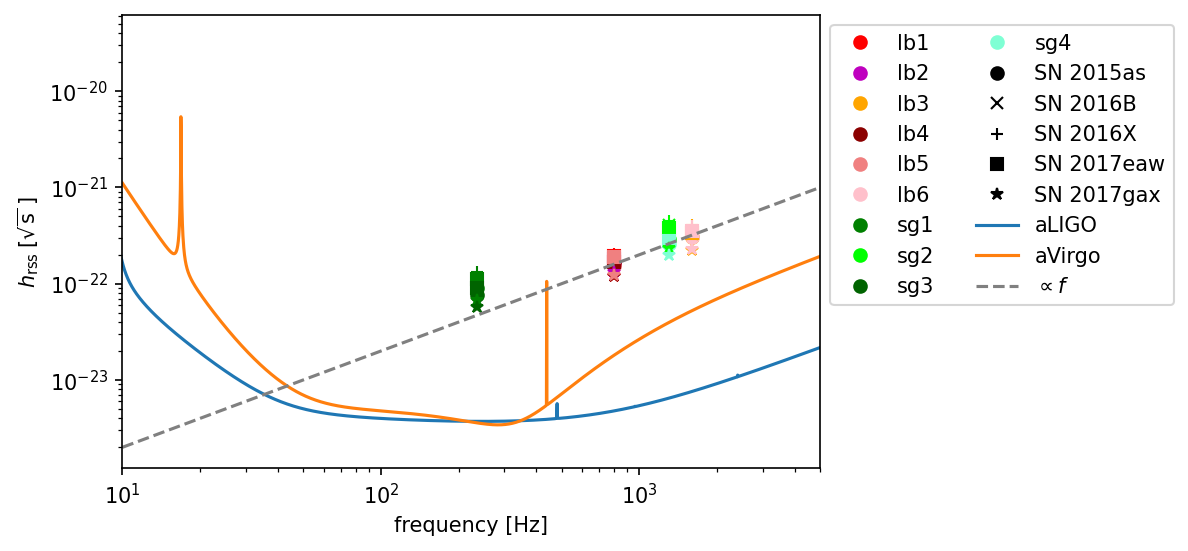

In [14]:
print ("Comparison of the the upper limits set for hrss with the sensitivity curve of the detectors."+
"Note the general trend of the limit increasing with frequency due to the shape of the sensitivity curve.")
plt.figure(figsize=(6,4),dpi=150)
for SNkey in SNs.keys(): 
    for SGkey in SGs.keys():
        key = (SNkey,SGkey)
        GW=GWs[key]
        SG=SGs[SGkey]
        plt.plot(SG.f,GW.hrss,marker=ms[SNkey],c=cs[SGkey],ls="")
plt.yscale("log")
plt.xscale("log")
for SGkey in SGs.keys():
    plt.plot(-100,-100,marker="o",ls="",c=cs[SGkey],label=SGs[SGkey].name)
for SNkey in SNs.keys():
    plt.plot(-100,-100,marker=ms[SNkey],ls="",c="k",label=SNs[SNkey].name)
plt.ylabel(r"$h_{\rm rss}\; [\sqrt{\rm s}\; ]$")
plt.xlabel("frequency [Hz]")
plt.plot(f_L, asd_L, label="aLIGO")
plt.plot(f_V, asd_V, label="aVirgo")
plt.plot(f_V, 2e-25*f_V,"--",c="grey", label=r"$\propto f$")
plt.legend(loc="upper left", frameon=True,bbox_to_anchor=(1.,1.),ncol=2,)

plt.xlim((10,5000))
plt.savefig("hrssvsfreq.png",bbox_inches = 'tight')
plt.show()

Plot of the GW energy upper limit as a function of frequency.


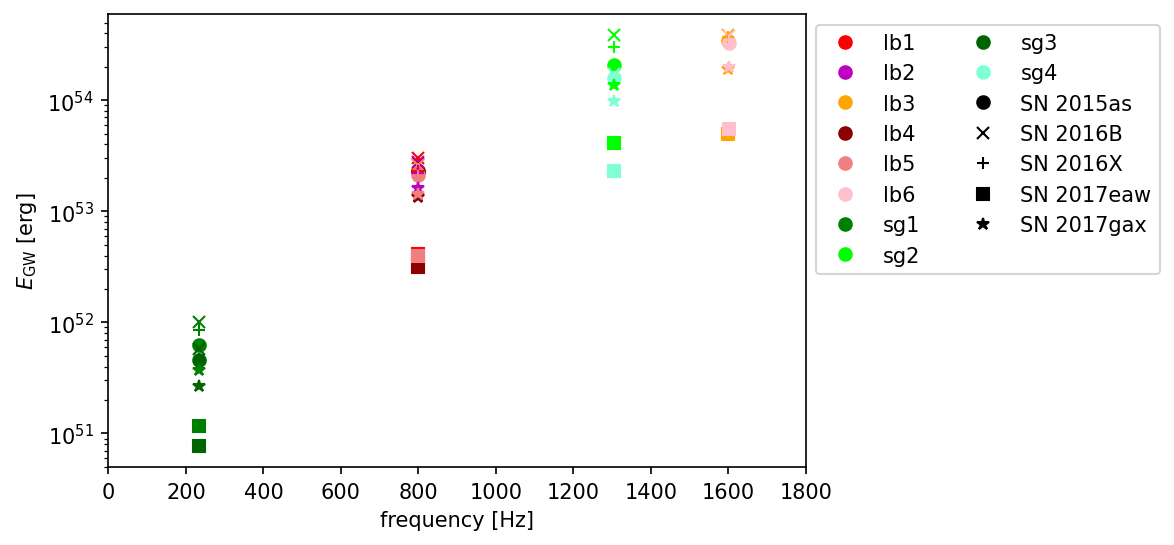

In [15]:
print("Plot of the GW energy upper limit as a function of frequency.")
plt.figure(figsize=(6,4),dpi=150)
for SNkey in SNs.keys(): 
    for SGkey in SGs.keys():
        key = (SNkey,SGkey)
        GW=GWs[key]
        SN=SNs[SNkey]
        SG=SGs[SGkey]
        plt.plot(SG.f,GW.EGW,marker=ms[SNkey],c=cs[SGkey],ls="")
plt.yscale("log")
for SGkey in SGs.keys():
    plt.plot(-100,-100,marker="o",ls="",c=cs[SGkey],label=SGs[SGkey].name)
for SNkey in SNs.keys():
    plt.plot(-100,-100,marker=ms[SNkey],ls="",c="k",label=SNs[SNkey].name)
plt.ylabel(r"$E_{\rm GW}$ [erg]")
plt.xlabel("frequency [Hz]")
plt.legend(loc="upper left", frameon=True,bbox_to_anchor=(1.,1.),ncol=2)
plt.xlim((0,1800))
plt.show()

Comparision of hrms upper limits with sensitivity curve. Note that longer signals (lb series) can bedetected at lower rms values than shorter signals (sg series). This means that cwb is mostly sensitive to hrss (total signal energy) rather than hrms (signal luminosity).


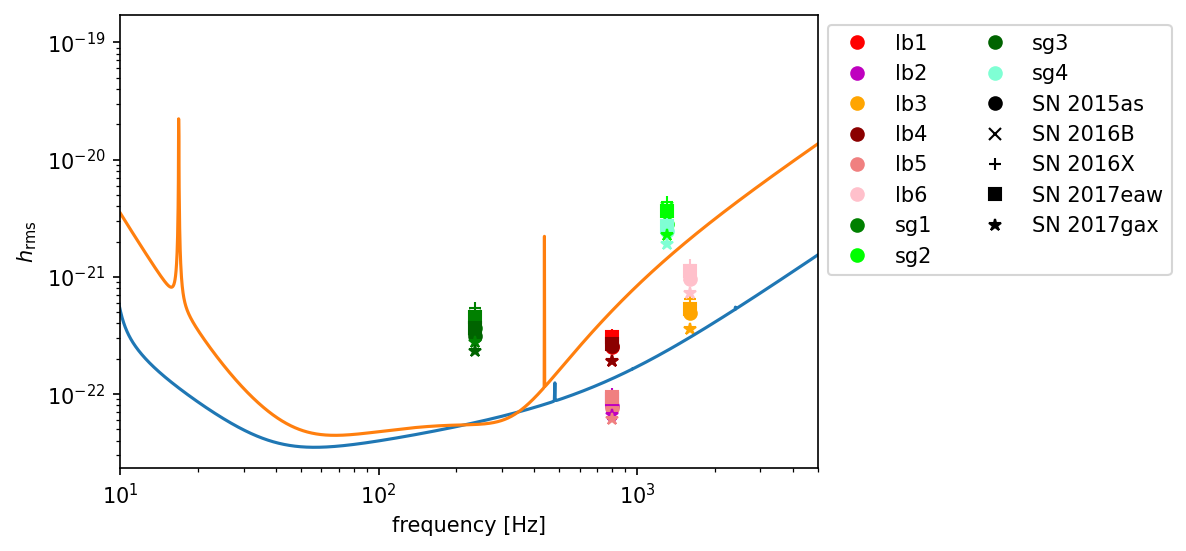

In [16]:
# If we divide hrss upper limits [sqrt[s]] by the duration of the signal sqrt(tau), 
# we get hrms [dimensionless]. 
print("Comparision of hrms upper limits with sensitivity curve. Note that longer signals (lb series) can be"
      "detected at lower rms values than shorter signals (sg series). This means that cwb is mostly "
      +"sensitive to hrss (total signal energy) rather than hrms (signal luminosity).")
plt.figure(figsize=(6,4),dpi=150)
for SNkey in SNs.keys(): 
    for SGkey in SGs.keys():
        key = (SNkey,SGkey)
        GW=GWs[key]
        SG=SGs[SGkey]
        plt.plot(SG.f,GW.hrms,marker=ms[SNkey],c=cs[SGkey],ls="")
plt.yscale("log")
plt.xscale("log")
for SGkey in SGs.keys():
    plt.plot(-100,-100,marker="o",ls="",c=cs[SGkey],label=SGs[SGkey].name)
for SNkey in SNs.keys():
    plt.plot(-100,-100,marker=ms[SNkey],ls="",c="k",label=SNs[SNkey].name)
plt.ylabel(r"$h_{\rm rms}$")
plt.xlabel("frequency [Hz]")
plt.legend(loc="upper left", frameon=True,bbox_to_anchor=(1.,1.),ncol=2)
plt.plot(f_L, asd_L*np.sqrt(f_L))
plt.plot(f_V, asd_V*np.sqrt(f_V))
plt.xlim((10,5000))
plt.show()

Upper limits on epsilon*Izz depending on frequency. Note that there is not a clear trend because the limits depend also on tau.


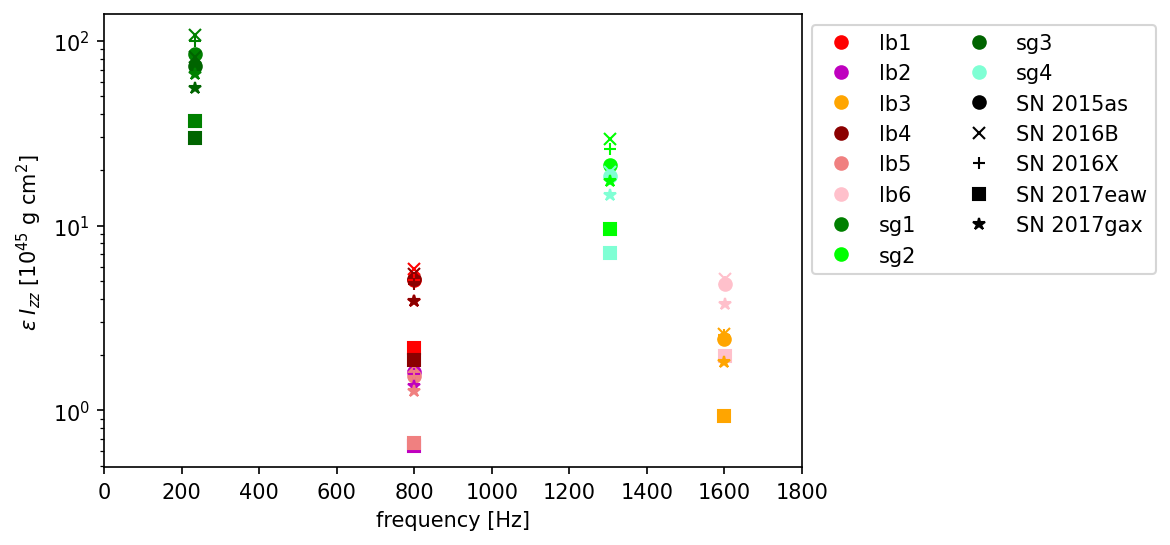

In [17]:
# ----- Upper limits on epsilon*Izz depending on  frequency ------
print("Upper limits on epsilon*Izz depending on frequency. Note that there"
      +" is not a clear trend because the limits depend also on tau.")
plt.figure(figsize=(6,4),dpi=150)
for SNkey in SNs.keys():
    SN=SNs[SNkey]
    for SGkey in SGs.keys():
        SG=SGs[SGkey]
        key = (SNkey,SGkey)
        if key in GWs:
            GW=GWs[key]
            lbl=""
            i=0
            plt.plot(SG.f,GW.Izzeps/1e45,marker=ms[SNkey],c=cs[SGkey],ls="",label=lbl)

plt.yscale("log")
for SGkey in SGs.keys():
    plt.plot(-100,-100,marker="o",ls="",c=cs[SGkey],label=SGs[SGkey].name)
for SNkey in SNs.keys():
    plt.plot(-100,-100,marker=ms[SNkey],ls="",c="k",label=SNs[SNkey].name)
plt.ylabel(r"$\epsilon \; I_{zz}$ [$10^{45}$ g cm$^2$] ")
plt.xlabel("frequency [Hz]")
plt.legend(loc="upper left", frameon=True,bbox_to_anchor=(1.,1.),ncol=2)
#plt.ylim((0.01,1e3))
plt.xlim((0,1800))
plt.show()

Upper limits on epsilon*Izz depending on tau. Note that there is not a clear trend because the limits depend also on the frequency.


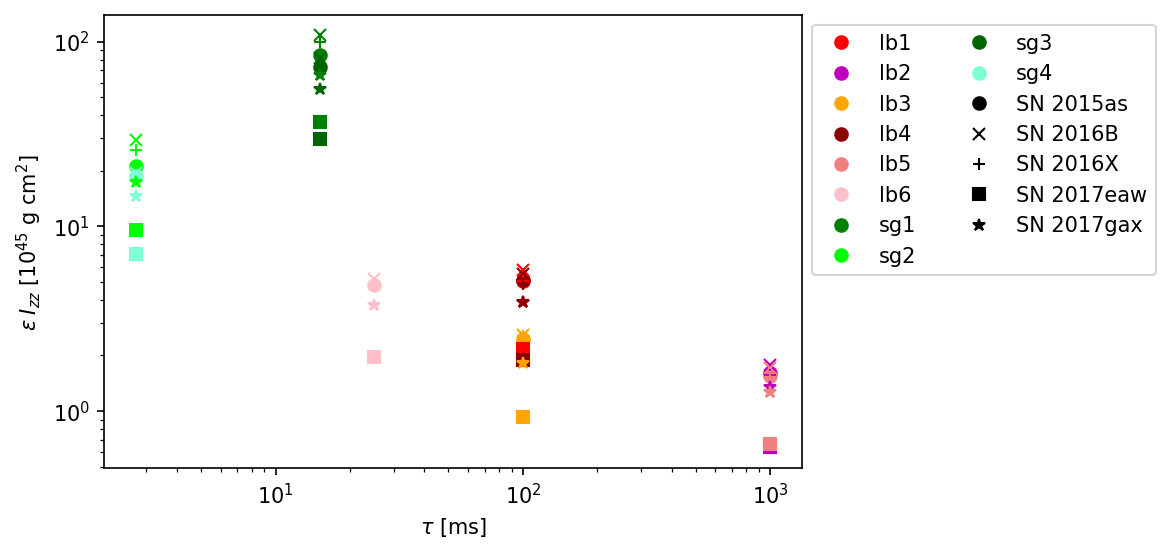

In [18]:
# ----- Upper limits on epsilon*Izz depending on duration ------
print("Upper limits on epsilon*Izz depending on tau. Note that there"
      +" is not a clear trend because the limits depend also on the frequency.")
plt.figure(figsize=(6,4),dpi=150)
for kSN in SNs.keys():
    SN=SNs[kSN]
    for kSG in SGs.keys():
        SG=SGs[kSG]
        key = (kSN,kSG)
        if key in GWs:
            GW=GWs[key]
            lbl=""
            i=0
            plt.plot(SG.tau*1000,GW.Izzeps/1e45,marker=ms[kSN],c=cs[kSG],ls="",label=lbl)

plt.yscale("log")
plt.xscale("log")
for SGkey in SGs.keys():
    plt.plot(-100,-100,marker="o",ls="",c=cs[SGkey],label=SGs[SGkey].name)
for SNkey in SNs.keys():
    plt.plot(-100,-100,marker=ms[SNkey],ls="",c="k",label=SNs[SNkey].name)
plt.ylabel(r"$\epsilon \; I_{zz}$ [$10^{45}$ g cm$^2$] ")
plt.xlabel(r"$\tau$ [ms]")
plt.legend(loc="upper left", frameon=True,bbox_to_anchor=(1.,1.),ncol=2)
#plt.ylim((0.01,1e3))
#plt.xlim((0,1800))
plt.show()

Upper limits on epsilon*Izz depending on tau and f.


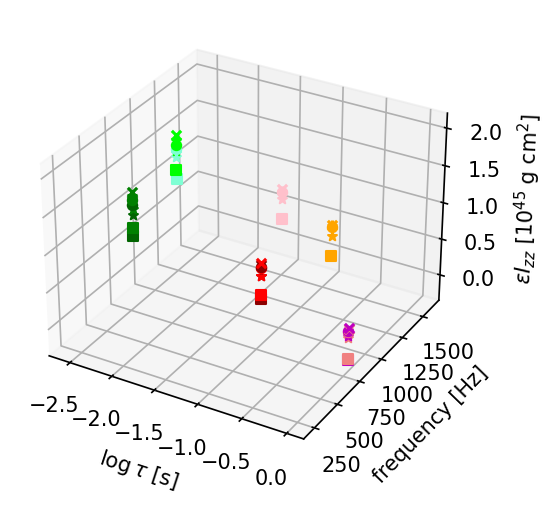

In [19]:
print("Upper limits on epsilon*Izz depending on tau and f.")
fig=plt.figure(figsize=(6,4),dpi=150)
ax = fig.add_subplot(projection='3d')
for SNkey in SNs.keys():
    SN=SNs[SNkey]
    for SGkey in SGs.keys():
        SG=SGs[SGkey]
        key = (SNkey,SGkey)
        if key in GWs:
            GW=GWs[key]
            lbl=""
            i=0
            ax.scatter(np.log10(SG.tau),SG.f,np.log10(GW.Izzeps/1e45),marker=ms[SNkey],c=cs[SGkey])#,ls="",label=lbl)

ax.set_zlabel(r"$\epsilon I_{zz}$ [$10^{45}$ g cm$^2$] ")
ax.set_xlabel(r"$\log \tau$ [s]")
ax.set_ylabel("frequency [Hz]")
plt.show()

Normalized upper limits: epsilon*Izz*f0*sqrt(tau). The results appear to depend mostly on distance.


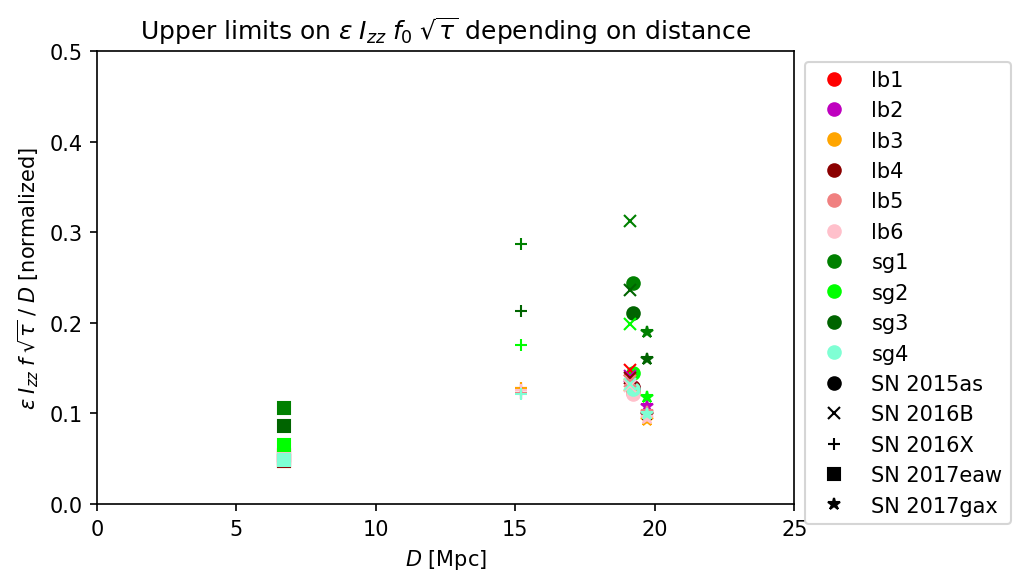

In [20]:
print("Normalized upper limits: epsilon*Izz*f0*sqrt(tau). The results appear to depend mostly on distance.")
plt.figure(figsize=(6,4),dpi=150)
plt.title(r"Upper limits on $\epsilon\;I_{zz}\; f_0 \; \sqrt{\tau}$ depending on distance")
for SNkey in SNs.keys():
    SN=SNs[SNkey]
    for SGkey in SGs.keys():
        SG=SGs[SGkey]
        key = (SNkey,SGkey)
        if key in GWs:
            GW=GWs[key]
            lbl=""
            i=0
            plt.plot(SN.D/1e6/pc,(GW.Izzeps/1e45)*(SG.f/1000)*np.sqrt(SG.tau/100)
                     ,marker=ms[SNkey],c=cs[SGkey],ls="",label=lbl)

#plt.yscale("log")
#plt.xscale("log")
for SGkey in SGs.keys():
    plt.plot(-100,-100,marker="o",ls="",c=cs[SGkey],label=SGs[SGkey].name)
for SNkey in SNs.keys():
    plt.plot(-100,-100,marker=ms[SNkey],ls="",c="k",label=SNs[SNkey].name)
plt.ylabel(r"$\epsilon \; I_{zz} \; f \; \sqrt{\tau} \; / \;D$ [normalized]")
plt.xlabel(r"$D$ [Mpc]")
plt.legend(loc="upper left", frameon=True,bbox_to_anchor=(1.,1.))
plt.ylim((0,0.5))
plt.xlim((0,25))
plt.show()

In [21]:
#---- Store all data in one array for 3D plots and statistics ---
N=0
for SGkey in SGs.keys():
    for SNkey in SNs.keys():
        N+=1
x=np.zeros(N)
y=np.zeros(N)
z=np.zeros(N)
xSN=[]
xSG=[]

i=0
for SGkey in SGs.keys():
    SG=SGs[SGkey]
    for SNkey in SNs.keys():
        SN=SNs[SNkey]
        key = (SNkey,SGkey)
        if key in GWs:
            GW=GWs[key]
            x[i] = SG.tau
            y[i] = SG.f
            z[i] = GW.Izzeps
            xSN.append(SNkey)
            xSG.append(SGkey)
            i+=1
# Compute the rescaled value: epsilon*Izz*f0*sqrt(tau)/D
z2=np.zeros(len(z))
for i in range(len(z)):
    SN=SNs[xSN[i]]
    SG=SGs[xSG[i]]
    z2[i]=z[i]*SG.f*np.sqrt(SG.tau)/SN.D # in cgs

In [22]:
# Average value of the upper limit
z2mean=np.mean(z2)
z2std=np.std(z2)
print("epsilon*Izz*f0*sqrt(tau)/D=(%3.2f +- %3.2f) x 10^20 g cm /sqrt(s)" % (z2mean/1e20,z2std/1e20))
z2norm = 1e45*1000*np.sqrt(0.1)/(6e6*pc)
print("(epsilon*Izz)",
      "=(%3.2f +- %3.2f) * (1000 Hz/f0) * sqrt(0.1 s/tau) / (6 Mpc/D) x 10^45 g cm^2" % (z2mean/z2norm,z2std/z2norm))

epsilon*Izz*f0*sqrt(tau)/D=(271.03 +- 98.92) x 10^20 g cm /sqrt(s)
(epsilon*Izz) =(1.59 +- 0.58) * (1000 Hz/f0) * sqrt(0.1 s/tau) / (6 Mpc/D) x 10^45 g cm^2


Upper limits on epsilon*Izz depending on tau and f. There is a cleardependence from the lower left (higher values) to the upper right (lower values).


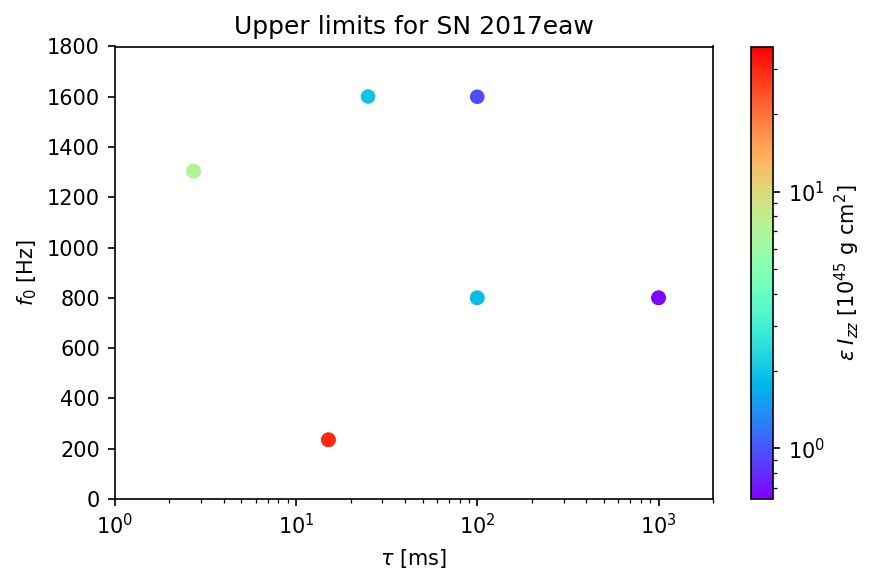

In [23]:
# ----- Upper limits on epsilon*Izz depending on duration, for a given supernova------
SNkey="SN2017eaw"
print("Upper limits on epsilon*Izz depending on tau and f. There is a clear"
     +"dependence from the lower left (higher values) to the upper right (lower values).")
plt.figure(figsize=(6,4),dpi=150)
idx=[idx for idx, element in enumerate(xSN) if element == SNkey]
plt.scatter(x[idx]*1000,y[idx],c=z[idx]/1e45, norm=colors.LogNorm(),cmap="rainbow")

plt.xscale("log")

plt.xlabel(r"$\tau$ [ms]")
plt.ylabel(r"$f_0$ [Hz]")
plt.xlim((1,2000))
plt.ylim((0,1800))

plt.title("Upper limits for "+SNs[SNkey].name)

plt.colorbar(label=r"$\epsilon \; I_{zz}$ [$10^{45}$ g cm$^2$]")

plt.tight_layout()
plt.savefig("UpperLimits1.png",bbox_inches = 'tight')

plt.show()

/tmp/ipykernel_136736/2121752652.py:14: RuntimeWarning: invalid value encountered in true_divide
  grid_z = grid_z2 * SNs[SNkey].D/grid_y/np.sqrt(grid_x)
/tmp/ipykernel_136736/2121752652.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(grid_x*1000, grid_y, grid_z/1e45,norm=colors.LogNorm(),cmap="rainbow",vmin=zmin,vmax=zmax)
/tmp/ipykernel_136736/2121752652.py:18: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.pcolormesh(grid_x*1000, grid_y, grid_z/1e45,norm=colors.LogNorm(),cmap="rainbow",vmin=zmin,vmax=zmax)
/tmp/ipykernel_136

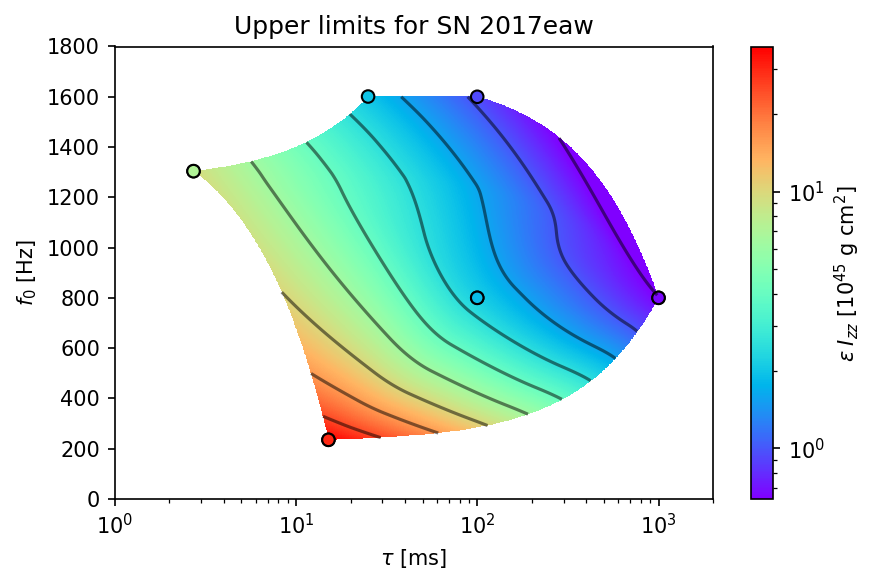

In [24]:
SNkey="SN2017eaw"

fig=plt.figure(figsize=(6,4),dpi=150)
plt.xscale("log")


xtmp=10**np.linspace(0,3.3,num=1000)/1000.
ytmp=np.linspace(0,1800,num=1000)
grid_x, grid_y = np.meshgrid(xtmp, ytmp)
# Interpolate directly z
#grid_z = griddata((x[idx],y[idx]),z[idx], (grid_x, grid_y), method='linear') # method = nearest, linear, cubic
# Interpolate z2 and compute z from that. This smoothers out the interpolation.
grid_z2 = griddata((x[idx],y[idx]),z2[idx], (grid_x, grid_y), method='cubic',fill_value=0)# method = nearest, linear, cubic
grid_z = grid_z2 * SNs[SNkey].D/grid_y/np.sqrt(grid_x)

zmin=np.min(z[idx])/1e45
zmax=np.max(z[idx])/1e45
plt.pcolormesh(grid_x*1000, grid_y, grid_z/1e45,norm=colors.LogNorm(),cmap="rainbow",vmin=zmin,vmax=zmax)
plt.contour(grid_x*1000, grid_y, np.log10(grid_z/1e45)+10,levels=10,ls="solid",colors="black",alpha=0.5) # add +10 to avoid dashed lines in negative values
plt.scatter(x[idx]*1000,y[idx],c=z[idx]/1e45, norm=colors.LogNorm(),cmap="rainbow",vmin=zmin,vmax=zmax,edgecolors="k")

#tmp= 15.87e45 * (100/grid_y) * np.sqrt(0.1/grid_x) / (6e6*pc/SNs[SNkey].D)
#levels=10**np.linspace(np.log10(zmin), np.log10(zmax), num=10)
#plt.contour(grid_x*1000, grid_y, tmp/1e45,levels=levels,ls="solid",colors="red",alpha=0.5) 

plt.xscale("log")
plt.title("Upper limits for "+SNs[SNkey].name)

plt.xlabel(r"$\tau$ [ms]")
plt.ylabel(r"$f_0$ [Hz]")
plt.xlim((1,2000))
plt.ylim((0,1800))

plt.colorbar(label=r"$\epsilon \; I_{zz}$ [$10^{45}$ g cm$^2$] ")


plt.tight_layout()
plt.savefig("UpperLimits2.png",bbox_inches = 'tight')

plt.show()

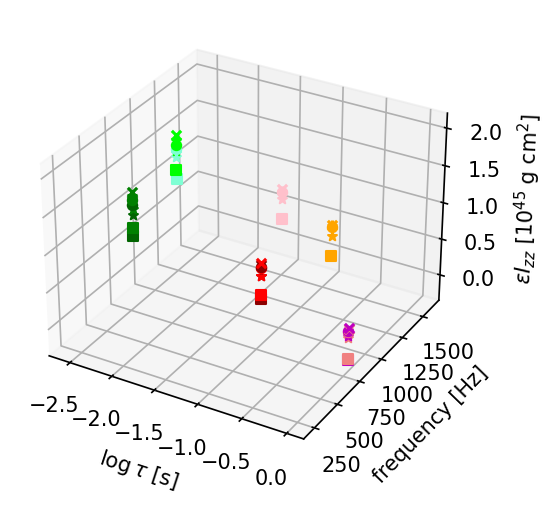

In [25]:
fig=plt.figure(figsize=(6,4),dpi=150)
ax = fig.add_subplot(projection='3d')
for SNkey in SNs.keys():
    SN=SNs[SNkey]
    for SGkey in SGs.keys():
        SG=SGs[SGkey]
        key = (SNkey,SGkey)
        if key in GWs:
            GW=GWs[key]
            lbl=""
            i=0
            ax.scatter(np.log10(SG.tau),SG.f,np.log10(GW.Izzeps/1e45),marker=ms[SNkey],c=cs[SGkey])#,ls="",label=lbl)

ax.set_zlabel(r"$\epsilon I_{zz}$ [$10^{45}$ g cm$^2$] ")
ax.set_xlabel(r"$\log \tau$ [s]")
ax.set_ylabel("frequency [Hz]")
plt.show()